File where code is written, tested, and integrated. \
Middlebury Stereo Datasets: https://vision.middlebury.edu/stereo/data/

In [2]:
import cv2
import numpy as np
import sklearn 
import igraph
import matplotlib.pyplot as plt
import math
import multiprocessing
import os
os.system("taskset -p 0xff %d" % os.getpid())

1

In [15]:
def load_picture(pic1, pic2, downscale=True):
    imgL = cv2.imread(pic1, cv2.IMREAD_GRAYSCALE)
    imgR = cv2.imread(pic2, cv2.IMREAD_GRAYSCALE)
    imgL_small = cv2.resize(imgL, (0,0), fx=1/7, fy=1/7) 
    imgR_small = cv2.resize(imgR, (0,0), fx=1/7, fy=1/7) 
    fig = plt.figure(figsize=(10, 7))
    fig.add_subplot(1, 2, 1)
    if(downscale):
        plt.imshow(imgL_small, cmap='gray')
        plt.axis('off')
        fig.add_subplot(1, 2, 2)
        plt.imshow(imgR_small, cmap='gray')
        plt.axis('off')
    else:
        plt.imshow(imgL, cmap='gray')
        plt.axis('off')
        fig.add_subplot(1, 2, 2)
        plt.imshow(imgR, cmap='gray')
        plt.axis('off')
    plt.show()
    if(downscale):
        return imgL_small, imgR_small
    else:
        return imgL, imgR

In [4]:
class Energy:
    def __init__(self):
        self.graph = None
        self.Econst = 0
        self.Gconst = 0
        #igraph requires "preprocessing" to initialize edge with weights
        #see https://igraph.org/python/doc/tutorial/generation.html "From nodes to edges" for more detail
        self.vertex_num = 2 # source vertex:0, terminal vertex:1
        self.edges = []
        self.capacity = []

    
    # Add a new binary variable as a node
    def add_node(self, E0=0, E1=0)->int:
        x_id = self.vertex_num
        self.vertex_num += 1
        self.vertex_num = int(self.vertex_num)
        self.add_term1(x_id, E0,E1)
        return x_id

    # Add a constant to the energy function
    def add_constant(self, E)->None:
        self.Gconst += E
        return

    # Add a term E(x) of one binary variable to the energy function,
    # where E(0) = E0, E(1) = E1. E0 and E1 can be arbitrary.
    def add_term1(self, x_id, E0, E1)->None:
        self.edges.extend(([0,int(x_id)], [int(x_id),1]))
        if(E0 > E1):
            self.capacity.extend((0, E0-E1))
        else:
            self.capacity.extend((E1-E0, 0))
        self.add_constant(np.min((E0,E1)))
        return
    
    # Add a  term E(x, y) of two binary variables to the energy function,
    # where E(0, 0) = A, E(0, 1) = B, E(1, 0) = C, E(1, 1) = D.
    # The term must be regular, i.e. E00 + E11 <= E01 + E10
    def add_term2(self, x_id, y_id, E00, E01, E10, E11)->None:
        # E = A B = B B + A-B 0 +    0    0
        #     C D   D D   A-B 0   B+C-A-D 0
        self.add_term1(int(x_id), E01, E11)
        self.add_term1(y_id, E00 - E01, 0)
        self.edges.extend(([int(x_id), int(y_id)], [int(y_id), int(x_id)]))
        self.capacity.extend((0, E01 + E10 - E00 - E11))
        return

    # Forbid (x, y) = (0, 1) by putting infinite value to
    # the edge from x to y
    def forbid01(self, x_id, y_id)->None:
        self.edges.extend(([int(x_id), int(y_id)], [int(y_id), int(x_id)]))
        self.capacity.extend((np.inf, 0))
        return
    
    def minimize(self)->int:
        self.graph = igraph.Graph(
            n = self.vertex_num,
            edges = self.edges,
            edge_attrs={'weight':self.capacity,
                        'label':self.capacity,
                        'curved': np.ones_like(self.capacity)},
            vertex_attrs={'label': np.arange(self.vertex_num)},
            directed = True
        )
        # print("self.capacity",self.capacity)
        # print("self.edges",self.edges)
        # print("running graph cut")
        self.mincut = self.graph.mincut(source = 0, target = 1, capacity="weight")
        # print("finished graph cut")
        # print("self.mincut.value",self.mincut.value)
        # print("self.Econst",self.Econst)
        return self.mincut.value + self.Gconst + self.Econst
    
    def visualize(self):
        visual_style = {}
        out_name = "graph.png"
        # Set bbox and margin
        visual_style["bbox"] = (400,400)
        visual_style["margin"] = 27
        # Set vertex colours
        visual_style["vertex_color"] = 'white'
        # Set vertex size
        visual_style["vertex_size"] = 45
        # Set vertex lable size
        visual_style["vertex_label_size"] = 22
        # # Don't curve the edges
        visual_style["edge_curved"] = False
        # Set the layout
        my_layout = self.graph.layout_lgl()
        visual_style["layout"] = my_layout
        # Plot the graph
        return(igraph.plot(self.graph, **visual_style))

In [5]:
e = Energy()
#E(x, y, z) = x - 2*y + 3*(1-z) - 4*x*y + 5*|y-z|
x = e.add_node()
y = e.add_node()
z = e.add_node()

e.add_term1(x, 0, 1)
e.add_term1(y, 0, -2)
e.add_term1(z, 3, 0)

e.add_term2(x, y, 0, 0, 0, -4)
e.add_term2(y, z, 0, 5, 5, 0)
e.forbid01(x, z)
e.minimize()

-5.0

In [6]:
OCCLUDED = -1
VAR_ALPHA = 1
VAR_ABSENT = 0
MAX_ITER = 2

def IS_VAR(var):
    return var>1 # 0: absent 1: alpha

class Solver:
    def __init__(self, limg, rimg, windowsize, maxdisparity, initial_f=None,  d=2, cutoff=30, K=None):
        self.limg = limg.astype(np.float64)
        self.rimg = rimg.astype(np.float64)
        # windowsize * 2 + 1 = full window length
        self.windowsize = windowsize #windowsize in data term
        # configuration (represented by disparity)
        if initial_f is not None:
            self.d_left = initial_f 
            self.d_right = np.zeros_like(initial_f)
            for i in range(self.limg.shape[0]):
                for j in range(self.limg.shape[1]):
                    p = (i,j)
                    dl = self.d_left[p]
                    if(dl != OCCLUDED):
                        self.d_right[p[0], p[0]+dl] = -dl
        else:
            self.d_left = np.full_like(limg.astype(int), -1)
            self.d_right = np.full_like(rimg.astype(int), -1)
        # disparity matching window along the rectified image rows
        self.maxdisparity = maxdisparity
        # Graph representation of energy function
        self.energy = None
        self.d=d #d-norm in data term
        self.cutoff=cutoff #cutoff value of abs difference in data term
        self.preE = np.inf # previous minimized energy
        # arrays index by pixel p to track the nodes associated to each pixel
        self.varsA = np.zeros_like(self.limg)
        self.vars0 = np.zeros_like(self.limg)

        self.limg_padded = np.pad(self.limg, windowsize, mode="reflect")
        self.rimg_padded = np.pad(self.rimg, windowsize, mode="reflect")

        if K is not None:
            self.K = K
            self.lam = K/5
        else:
            self.tune_K()

    def disparity(self, asn):
        # assignment a - (p, q)
        p, q = asn
        return q[1] - p[1]
    
    def is_active_assignment(self, a):
        return self.f[a[0][0], a[0][1], a[0][1] - a[1][1]]

    #data + occlusion
    def data_occlusion_value(self, asn, K, debug=False):
        p,q = asn
        lwindow = self.limg_padded[ p[0]:p[0]+2*self.windowsize+1,
                                    p[1]:p[1]+2*self.windowsize+1]
        rwindow = self.rimg_padded[ q[0]:q[0]+2*self.windowsize+1,
                                    q[1]:q[1]+2*self.windowsize+1]
        if debug:
            print('lwindow',lwindow)
            print('rwindow',rwindow)
        abs_difference = np.abs(lwindow-rwindow)
        abs_difference_trimmed = abs_difference * (abs_difference<=30) + 30 * (abs_difference>30)
        E_data = np.sum(abs_difference_trimmed ** self.d)
        return E_data - K

    def build_node_with_data_occlusion(self, p, alpha):
        '''
        creates appropriate nodes and adds them to varsA and vars0
        p: pixel in the left image
        alpha: alpha-expansion disparity value
        '''
        d = self.d_left[p]
        if d == alpha:
            # a in A_alpha and is active remains active
            asn = (p, (p[0], p[1]+d))
            Dp = self.data_occlusion_value(asn, self.K)
            self.energy.add_constant(Dp)
            self.varsA[p] = VAR_ALPHA
            self.vars0[p] = VAR_ALPHA
            #a in A_alpha and is inative changes depending on g
        else:
            if p[1]+alpha<self.limg.shape[1]:
                # p has inactive assignnent with disparity = alpha
                asn = (p, (p[0], p[1]+alpha))
                Dp = self.data_occlusion_value(asn, self.K)
                a = self.energy.add_node(0, Dp)
                self.varsA[p] = a
            else:
                # p+alpha is not in right image
                self.varsA[p] = VAR_ABSENT
            
            if d != OCCLUDED:
                # p has active assignemnt with disparity not= alpha
                asn = (p, (p[0], p[1]+d))
                Dp = self.data_occlusion_value(asn, self.K)
                o = self.energy.add_node(Dp, 0)
                self.vars0[p] = o
            else:
                # p has no active assignment
                self.vars0[p] = VAR_ABSENT

    def smoothness_value(self, asn1, asn2, lam):
        p1 = self.limg[asn1[0]]
        p2 = self.limg[asn2[0]]
        q1 = self.limg[asn1[1]]
        q2 = self.limg[asn2[1]]
        if(max(abs(p1-p2), abs(q1-q2))<8):
            return 3*lam
        else:
            return lam
        
    def build_smoothness(self, p1, p2, alpha):
        a1 = self.varsA[p1]
        a2 = self.varsA[p2]
        o1 = self.vars0[p1]
        o2 = self.vars0[p2]
        d1 = self.d_left[p1]
        d2 = self.d_left[p2]

        # by the definition of the smoothness term, we only care about p1 and p2 if they are adjacent
        # pixel. The assignments concerning p1 and p2 should have the same disparity, since the al-
        # -pha expansion move only changes inactive assignment with disp=alpha and active assignment
        # with disp!=alpha, we only concern ourselves with assignment disp=alpha and disp= active-ass-
        # ignment_of(p1, p2)

        #disp = alpha
        if(self.varsA[p1]!=VAR_ABSENT and self.varsA[p2]!=VAR_ABSENT):
            # both p1 and p2 has assignment with disp=alpha in rimg
            # at least one of p1 and p2 has inactive assignment with disp=alpha
            asn1 = (p1, (p1[0], p1[1]+alpha))
            asn2 = (p2, (p2[0], p2[1]+alpha))
            V = self.smoothness_value(asn1, asn2, self.lam)
            if(a1!=VAR_ALPHA and a2!=VAR_ALPHA):
                self.energy.add_term2(a1,a2,0,V,V,0)
            elif(a1!=VAR_ALPHA and a2==VAR_ALPHA):
                self.energy.add_term1(a1,V,0)
            elif(a1==VAR_ALPHA and a2!=VAR_ALPHA):
                self.energy.add_term1(a2,V,0)

        #disp= active-assignment_of(p1)=active-assignment_of(p2)
        if(d1==d2 and IS_VAR(o1) and IS_VAR(o2)):
            asn1 = (p1, (p1[0], p1[1]+d1))
            asn2 = (p2, (p2[0], p2[1]+d2))
            V = self.smoothness_value(asn1, asn2, self.lam)
            self.energy.add_term2(o1, o2, 0, V, V, 0)

        #disp= active-assignment_of(p1)!=active-assignment_of(p2)
        if(d1!=d2 and IS_VAR(o1) and p2[1]+d1<self.limg.shape[1]):
            asn1 = (p1, (p1[0], p1[1]+d1))
            asn2 = (p2, (p2[0], p2[1]+d1))
            V = self.smoothness_value(asn1, asn2, self.lam)
            self.energy.add_term1(o1, V, 0)
        
        #disp= active-assignment_of(p2)!=active-assignment_of(p1)
        if(d2!=d1 and IS_VAR(o2) and p1[1]+d2<self.limg.shape[1]):
            asn1 = (p1, (p1[0], p1[1]+d2))
            asn2 = (p2, (p2[0], p2[1]+d2))
            V = self.smoothness_value(asn1, asn2, self.lam)
            self.energy.add_term1(o2, V, 0)
            
        return


    def build_uniqueness(self, p, alpha):
        # Build edges in graph enforcing uniqueness at pixels p and p+d:
        # - prevent (p, p+d) and (p, p+a) from being both active.
        # - prevent (p, p+d) and (p+d-alpha, p+d) from being both active.
        o = self.vars0[p]

        if not IS_VAR(o):
            return
        
        # enforce unique image of p
        a = self.varsA[p]
        if a != VAR_ABSENT:
            self.energy.forbid01(o, a)

        # enforce unique antecedent of p+d
        d = self.d_left[p]
        # d cannot be OCCLUDED
        p2 = (p[0],p[1] + d - alpha)
        if 0 <= p[1] <= self.limg.shape[1]:
            a2 = self.varsA[p2]
            # a cannot be active
            self.energy.forbid01(o, a2)

    def neighbors(self, p):
        p_1, p_2 = p
        neighbors = [(p_1+1, p_2), (p_1, p_2+1), (p_1+1, p_2+1)]
        return neighbors
    
    def build_energy(self, alpha):
        self.energy = Energy()
        for i in range(self.limg.shape[0]):
            for j in range(self.limg.shape[1]):
                p =(i,j)
                self.build_node_with_data_occlusion(p, alpha)
                self.build_uniqueness(p, alpha)

        # all neighbors in bound
        for i in range(self.limg.shape[0]-1):
            for j in range(self.limg.shape[1]-1):
                p1 =(i,j)
                for p2 in self.neighbors(p1):
                    self.build_smoothness(p1, p2, alpha)

        # right neighbors out of bound
        for i in range(self.limg.shape[0]-1):
            # right-most column
            j = self.limg.shape[1] - 1
            p1 = (i, j)
            p2 = (i-1, j)
            self.build_smoothness(p1, p2, alpha)

        # down neighbors out of bound
        for j in range(self.limg.shape[1]-1):
            # bottom column
            i = self.limg.shape[0] - 1
            p1 = (i, j)
            p2 = (i, j + 1)
            self.build_smoothness(p1, p2, alpha)

    
    def minimize_energy(self):
        return self.energy.minimize()

    def recover_configuration(self, alpha):
        partition = self.energy.mincut.partition
        g_alpha = np.zeros(self.energy.vertex_num)
        g_alpha[partition[1]] = 1
        # print(partition)
        for i in range(self.limg.shape[0]):
            for j in range(self.limg.shape[1]):
                p = (i,j)
                alpha_node_id = self.varsA[p]
                d_node_id = self.vars0[p]
                if IS_VAR(d_node_id) and g_alpha[int(d_node_id)]==1:
                    self.d_left[p] = OCCLUDED
                if IS_VAR(alpha_node_id) and g_alpha[int(alpha_node_id)]==1:
                    self.d_left[p] = alpha
        self.d_right_from_d_left()
                
    def d_right_from_d_left(self):
        for i in range(self.limg.shape[0]):
            for j in range(self.limg.shape[1]):
                p = (i,j)
                dl = self.d_left[p]
                if(dl != OCCLUDED):
                    self.d_right[p[0], p[0]+dl] = -dl

    def expansion_move(self, alpha):
        # Compute the minimum alpha-expansion configuration
        # Return whether the move is different from previous E

        # build graph
        self.build_energy(alpha=alpha)

        oldE = self.preE
        # Max-flow, give the lowest-energy expansion move
        E = self.minimize_energy()
        # print("new E", E)
        if E < oldE:
            # lower energy, accept the expansion move
            self.recover_configuration(alpha)
            self.preE = E
            return True
        return False

    def tune_K(self):
        lower_one_fourth = int(self.maxdisparity/4)
        lower_one_fourth_sum = 0
        for i in range(self.limg.shape[0]):
            for j in range(self.limg.shape[1]):
                d_array = []
                for d in range(min(self.maxdisparity, self.limg.shape[1] - j)):
                    asn = ((i,j),(i,j+d))
                    d_array.append(self.data_occlusion_value(asn, 0))
                d_array.sort()
                lower_one_fourth_sum += np.sum(d_array[0:lower_one_fourth])
        self.K = lower_one_fourth_sum/(self.limg.shape[0]*self.limg.shape[1]*lower_one_fourth)
        self.lam = self.K/5
                

    def run(self):
        # Alpha-expansion move
        # assume min disparity = 0
        # randomize the order of alpha in each iter

        done = np.full((self.maxdisparity), 0)
        for iter in range(MAX_ITER):
            if np.sum(done) == done.shape[0]:
                break
            # randomize every iteration
            permutation = np.random.permutation(self.maxdisparity)
            for i in range(self.maxdisparity):
                alpha = permutation[i]
                if done[alpha]:
                    continue
                # calculate min energy for this alpha
                # print("current E", self.preE)
                if self.expansion_move(alpha):
                    done = np.full((self.maxdisparity), 0)
                done[alpha] = 1

    def add_smoothness(self, p1, p2):
            smoothness_term = 0
            d1 = self.d_left[p1]
            d2 = self.d_left[p2]
            if d1 == d2:
                return 0
            if d1 != OCCLUDED and \
                p2[1] + d1 < self.limg.shape[1]:
                smoothness_term += self.smoothness_value((p1, (p1[0], p1[1] + d1)), (p2, (p2[0], p2[1] + d1)), self.lam)
            
            if d2 != OCCLUDED and \
                p1[1] + d2 < self.limg.shape[1]:
                smoothness_term += self.smoothness_value((p1, (p1[0], p1[1] + d2)), (p2, (p2[0], p2[1] + d2)), self.lam)
            
            return smoothness_term

    def ComputeEnergy(self):
        
        # Compute current minimized energy
        # only use for debugging
        E = 0
        dovcount = 0
        activecount = 0
        for i in range(self.limg.shape[0]):
            for j in range(self.limg.shape[1]):
                p1 = (i, j)
                d1 = self.d_left[p1]
                if d1 != OCCLUDED:
                    dov = self.data_occlusion_value((p1, (i, j + d1)), self.K)
                    if(dov<0):
                        dovcount+=1
                    E += dov
                    activecount += 1
        print("dovcount", dovcount)
        print("activecount", activecount)
        print("E from data occlusion", E)
        E0 = E
        # all neighbors in bound
        for i in range(self.limg.shape[0]-1):
            for j in range(self.limg.shape[1]-1):
                p1 =(i,j)
                for p2 in self.neighbors(p1):
                    E += self.add_smoothness(p1, p2)


        # right neighbors out of bound
        for i in range(self.limg.shape[0]-1):
            # right-most column
            j = self.limg.shape[1] - 1
            p1 = (i, j)
            p2 = (i-1, j)
            E += self.add_smoothness(p1, p2)

        # down neighbors out of bound
        for j in range(self.limg.shape[1]-1):
            # bottom column
            i = self.limg.shape[0] - 1
            p1 = (i, j)
            p2 = (i, j + 1)
            E += self.add_smoothness(p1, p2)
        
        
        print("E from smoothness", E-E0)
        return E


## TODO

- alpha exapansion algorithm

- parameter tuning
    K and $\lambda$

- figure out initial configuration

- multi processing
https://medium.com/python-experiments/parallelising-in-python-mutithreading-and-mutiprocessing-with-practical-templates-c81d593c1c49



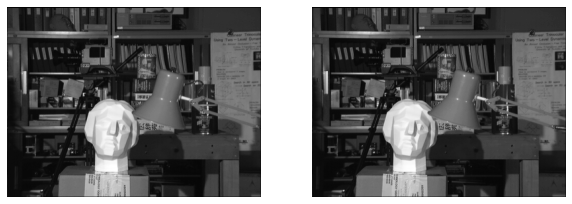

In [16]:
limg, rimg = load_picture('Data/tsukuba/im0.png', 'Data/tsukuba/im1.png', downscale=False)

In [8]:
recycle_naive_r = np.load("recycle_naive_r.npy")
recycle_naive_l = np.full_like(recycle_naive_r, -1)
for i in range(recycle_naive_r.shape[0]):
    for j in range(recycle_naive_r.shape[1]):
        d = int(recycle_naive_r[i,j])
        if(d >=0):
            recycle_naive_l[i,j-d] = d


In [12]:
print(rimg.shape)

(288, 384)


In [29]:
testSolver = Solver(rimg[0:50], limg[0:50], 2, 32,None ,d=2, cutoff=30)

In [30]:
testSolver.run()

In [12]:
testSolver.limg.shape

(50, 409)

In [13]:
testSolver.ComputeEnergy()

dovcount 16048
activecount 16346
E from data occlusion -29303203.143501077
E from smoothness 2783814.2648074776


-26519388.8786936

In [14]:
print(testSolver.K)

2174.175464547677


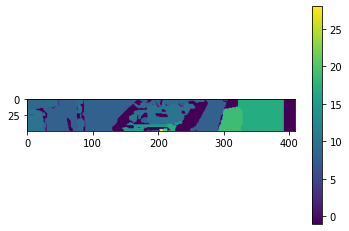

In [15]:
plt.imshow(testSolver.d_left)
plt.colorbar()
plt.show()

In [27]:
np.save(os.path.join('run\\recycle',str(0)+"to"+str(50)+".npy"), testSolver.d_left)